# Customer Churn Analysis - Part 3: Model Building
 
**Project**: Customer Churn Prediction  
**Notebook**: 03 - Model Training & Selection  
**Author**: Yunjae Jung  
**Date**: January 2026
 
## Objectives
- Load preprocessed data
- Split into train/test sets
- Train multiple classification models
- Perform hyperparameter tuning
- Compare model performance
- Select best model
- Save trained models

## 1. Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Processed Data

In [3]:
# Load final processed dataset
DATA_DIR = Path('../data/processed')
df = pd.read_csv(DATA_DIR / 'data_processed_final.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Churn rate: {df['Churn'].mean()*100:.2f}%")

Dataset loaded: (7043, 63)
Churn rate: 26.54%


## 3. Prepare Features and Target

In [4]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.shape[1]}")


Features shape: (7043, 62)
Target shape: (7043,)

Feature columns: 62


## 4. Train-Test Split

In [5]:
# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Train-Test Split:")
print("=" * 50)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nClass distribution in train set:")
print(f"  Retained (0): {(y_train==0).sum()} ({(y_train==0).mean()*100:.2f}%)")
print(f"  Churned (1): {(y_train==1).sum()} ({(y_train==1).mean()*100:.2f}%)")

print(f"\nClass distribution in test set:")
print(f"  Retained (0): {(y_test==0).sum()} ({(y_test==0).mean()*100:.2f}%)")
print(f"  Churned (1): {(y_test==1).sum()} ({(y_test==1).mean()*100:.2f}%)")


Train-Test Split:
Training set: 5634 samples (80.0%)
Test set: 1409 samples (20.0%)

Class distribution in train set:
  Retained (0): 4139 (73.46%)
  Churned (1): 1495 (26.54%)

Class distribution in test set:
  Retained (0): 1035 (73.46%)
  Churned (1): 374 (26.54%)


## 5. Baseline Models

### 5.1 Initialize Models

In [6]:
# Initialize baseline models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

print(f"Initialized {len(models)} models:")
for name in models.keys():
    print(f"  • {name}")

Initialized 4 models:
  • Logistic Regression
  • Decision Tree
  • Random Forest
  • Gradient Boosting


### 5.2 Train and Evaluate Baseline Models

In [7]:
# Store results
results = {}

print("\nTraining baseline models...")
print("=" * 80)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print('='*60)
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Print results
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\nCross-Validation (5-fold):")
    print(f"  Mean F1:   {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")



Training baseline models...

Training: Logistic Regression

Test Set Performance:
  Accuracy:  0.8077
  Precision: 0.6758
  Recall:    0.5294
  F1-Score:  0.5937
  ROC-AUC:   0.8465

Cross-Validation (5-fold):
  Mean F1:   0.5891 (+/- 0.0441)

Training: Decision Tree

Test Set Performance:
  Accuracy:  0.7367
  Precision: 0.5039
  Recall:    0.5187
  F1-Score:  0.5112
  ROC-AUC:   0.6669

Cross-Validation (5-fold):
  Mean F1:   0.5017 (+/- 0.0259)

Training: Random Forest

Test Set Performance:
  Accuracy:  0.7842
  Precision: 0.6159
  Recall:    0.4973
  F1-Score:  0.5503
  ROC-AUC:   0.8191

Cross-Validation (5-fold):
  Mean F1:   0.5477 (+/- 0.0536)

Training: Gradient Boosting

Test Set Performance:
  Accuracy:  0.7956
  Precision: 0.6483
  Recall:    0.5027
  F1-Score:  0.5663
  ROC-AUC:   0.8432

Cross-Validation (5-fold):
  Mean F1:   0.5825 (+/- 0.0498)


### 5.3 Compare Baseline Models


BASELINE MODEL COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV F1 (mean)
Logistic Regression    0.8077     0.6758  0.5294    0.5937   0.8465        0.5891
      Decision Tree    0.7367     0.5039  0.5187    0.5112   0.6669        0.5017
      Random Forest    0.7842     0.6159  0.4973    0.5503   0.8191        0.5477
  Gradient Boosting    0.7956     0.6483  0.5027    0.5663   0.8432        0.5825


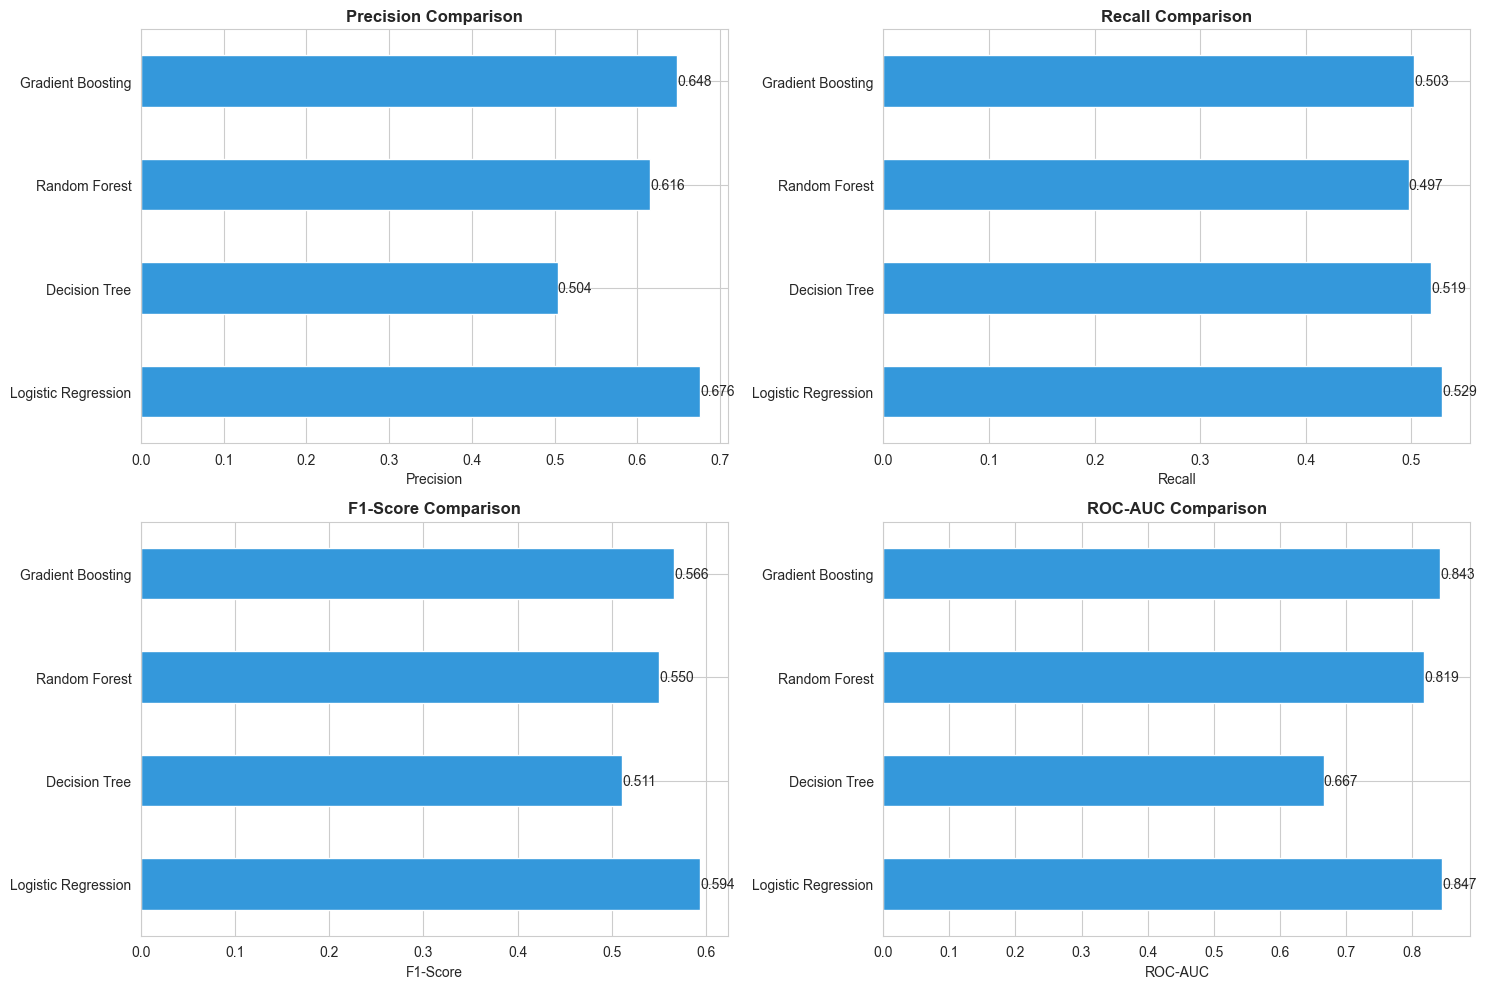

In [8]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'CV F1 (mean)': [results[m]['cv_mean'] for m in results.keys()]
}).round(4)

print("\n" + "=" * 80)
print("BASELINE MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metrics comparison
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='barh', ax=ax, 
                      color='#3498db', legend=False)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel(metric)
    ax.set_ylabel('')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.show()


## 6. Hyperparameter Tuning

### 6.1 Tune Random Forest

In [9]:
print("Tuning Random Forest...")
print("=" * 60)

# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\n✓ Best parameters: {rf_grid.best_params_}")
print(f"✓ Best CV F1 score: {rf_grid.best_score_:.4f}")

# Update results with tuned model
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

results['Random Forest (Tuned)'] = {
    'model': best_rf,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_rf),
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf
}

print(f"\nTuned RF Performance:")
print(f"  Accuracy:  {results['Random Forest (Tuned)']['accuracy']:.4f}")
print(f"  Precision: {results['Random Forest (Tuned)']['precision']:.4f}")
print(f"  Recall:    {results['Random Forest (Tuned)']['recall']:.4f}")
print(f"  F1-Score:  {results['Random Forest (Tuned)']['f1']:.4f}")
print(f"  ROC-AUC:   {results['Random Forest (Tuned)']['roc_auc']:.4f}")


Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✓ Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
✓ Best CV F1 score: 0.5801

Tuned RF Performance:
  Accuracy:  0.7949
  Precision: 0.6384
  Recall:    0.5241
  F1-Score:  0.5756
  ROC-AUC:   0.8385


### 6.2 Tune Gradient Boosting

In [10]:
print("Tuning Gradient Boosting...")
print("=" * 60)

# Define parameter grid
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}

# Grid search
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

print(f"\n✓ Best parameters: {gb_grid.best_params_}")
print(f"✓ Best CV F1 score: {gb_grid.best_score_:.4f}")

# Update results
best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)
y_pred_proba_gb = best_gb.predict_proba(X_test)[:, 1]

results['Gradient Boosting (Tuned)'] = {
    'model': best_gb,
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_gb),
    'y_pred': y_pred_gb,
    'y_pred_proba': y_pred_proba_gb
}

print(f"\nTuned GB Performance:")
print(f"  Accuracy:  {results['Gradient Boosting (Tuned)']['accuracy']:.4f}")
print(f"  Precision: {results['Gradient Boosting (Tuned)']['precision']:.4f}")
print(f"  Recall:    {results['Gradient Boosting (Tuned)']['recall']:.4f}")
print(f"  F1-Score:  {results['Gradient Boosting (Tuned)']['f1']:.4f}")
print(f"  ROC-AUC:   {results['Gradient Boosting (Tuned)']['roc_auc']:.4f}")


Tuning Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

✓ Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
✓ Best CV F1 score: 0.5830

Tuned GB Performance:
  Accuracy:  0.7999
  Precision: 0.6575
  Recall:    0.5134
  F1-Score:  0.5766
  ROC-AUC:   0.8434


## 7. Final Model Comparison


FINAL MODEL COMPARISON (Sorted by F1-Score)
                    Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
      Logistic Regression    0.8077     0.6758  0.5294    0.5937   0.8465
Gradient Boosting (Tuned)    0.7999     0.6575  0.5134    0.5766   0.8434
    Random Forest (Tuned)    0.7949     0.6384  0.5241    0.5756   0.8385
        Gradient Boosting    0.7956     0.6483  0.5027    0.5663   0.8432
            Random Forest    0.7842     0.6159  0.4973    0.5503   0.8191
            Decision Tree    0.7367     0.5039  0.5187    0.5112   0.6669


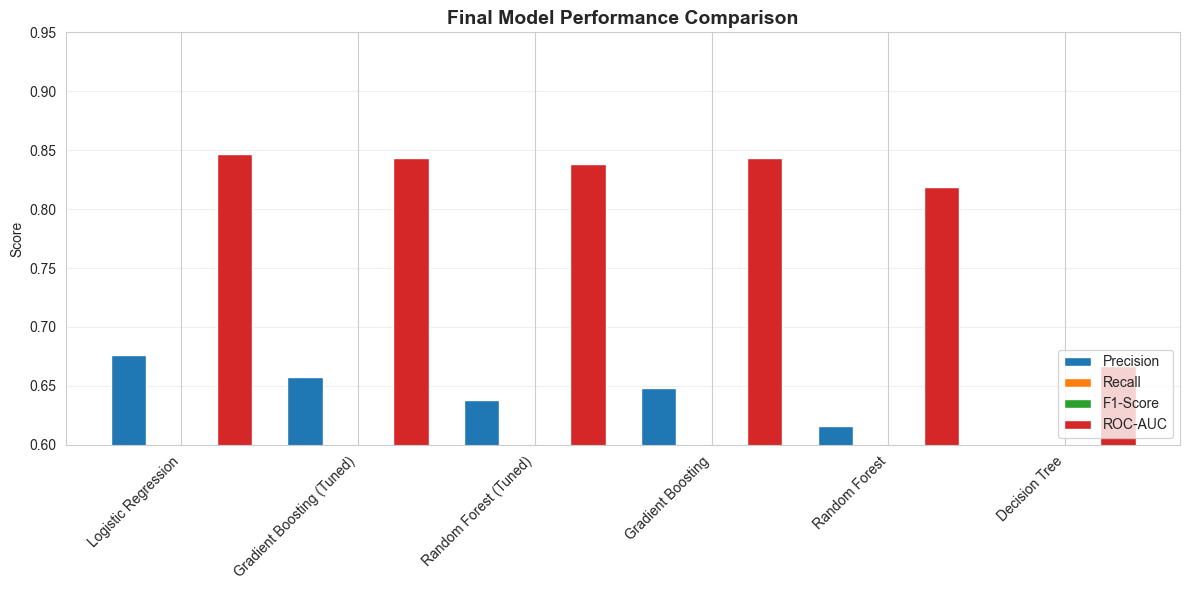

In [11]:
# Update comparison with tuned models
final_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False).round(4)

print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON (Sorted by F1-Score)")
print("=" * 80)
print(final_comparison.to_string(index=False))

# Visualize final comparison
fig, ax = plt.subplots(figsize=(12, 6))
final_comparison.set_index('Model')[['Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(
    kind='bar', ax=ax, width=0.8
)
ax.set_title('Final Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.95])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Best Model Selection

In [12]:
# Select best model based on F1-score
best_model_name = final_comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_f1 = results[best_model_name]['f1']

print("🏆 BEST MODEL SELECTED")
print("=" * 60)
print(f"Model: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
print(f"\nFull Performance:")
print(f"  Accuracy:  {results[best_model_name]['accuracy']:.4f}")
print(f"  Precision: {results[best_model_name]['precision']:.4f}")
print(f"  Recall:    {results[best_model_name]['recall']:.4f}")
print(f"  F1-Score:  {results[best_model_name]['f1']:.4f}")
print(f"  ROC-AUC:   {results[best_model_name]['roc_auc']:.4f}")


🏆 BEST MODEL SELECTED
Model: Logistic Regression
F1-Score: 0.5937

Full Performance:
  Accuracy:  0.8077
  Precision: 0.6758
  Recall:    0.5294
  F1-Score:  0.5937
  ROC-AUC:   0.8465


## 9. Model Performance Details

### 9.1 Confusion Matrix


Confusion Matrix:
[[940  95]
 [176 198]]

True Negatives (TN):  940 - Correctly predicted retained
False Positives (FP): 95 - Incorrectly predicted as churned
False Negatives (FN): 176 - Missed churned customers (COSTLY!)
True Positives (TP):  198 - Correctly predicted churned


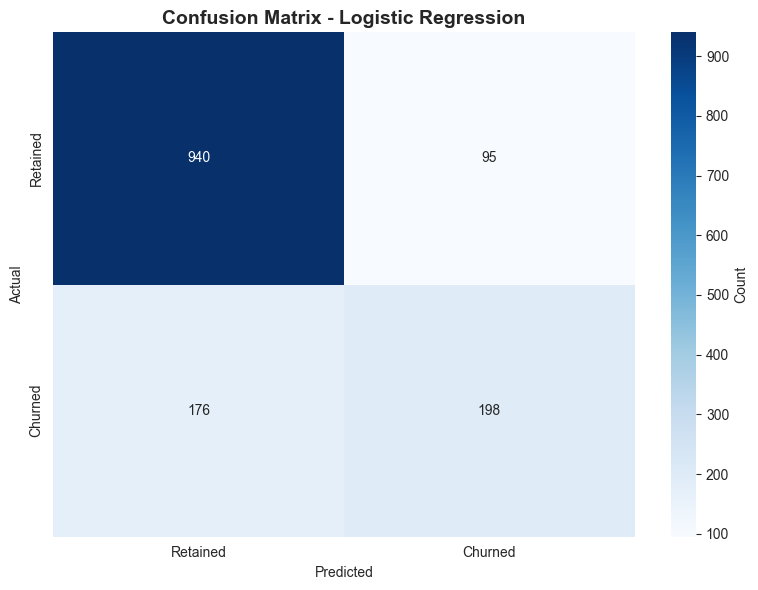

In [13]:
# Confusion matrix for best model
y_pred_best = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, y_pred_best)

print("\nConfusion Matrix:")
print("=" * 50)
print(cm)
print(f"\nTrue Negatives (TN):  {cm[0,0]} - Correctly predicted retained")
print(f"False Positives (FP): {cm[0,1]} - Incorrectly predicted as churned")
print(f"False Negatives (FN): {cm[1,0]} - Missed churned customers (COSTLY!)")
print(f"True Positives (TP):  {cm[1,1]} - Correctly predicted churned")

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'],
            cbar_kws={'label': 'Count'})
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.tight_layout()
plt.show()

### 9.2 Classification Report

In [14]:
# Detailed classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred_best, 
                          target_names=['Retained', 'Churned']))



Classification Report:
              precision    recall  f1-score   support

    Retained       0.84      0.91      0.87      1035
     Churned       0.68      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



### 9.3 ROC Curve

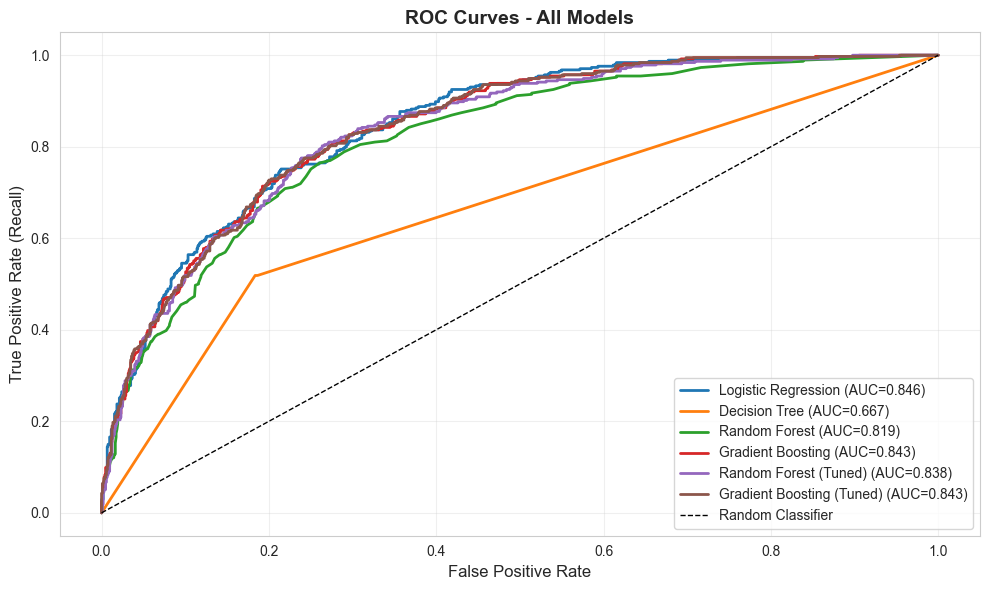

In [15]:
# Plot ROC curve for all models
fig, ax = plt.subplots(figsize=(10, 6))

for name in results.keys():
    y_proba = results[name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = results[name]['roc_auc']
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 9.4 Feature Importance

In [16]:
# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    print("\nTop 15 Most Important Features:")
    print("=" * 60)
    print(feature_importance.to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(data=feature_importance, y='feature', x='importance', 
                palette='viridis', ax=ax)
    ax.set_title(f'Top 15 Feature Importance - {best_model_name}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Feature')
    plt.tight_layout()
    plt.show()

## 10. Save Models

In [17]:
# Create models directory
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

# Save best model
best_model_path = MODELS_DIR / 'best_model.pkl'
joblib.dump(best_model, best_model_path)
print(f"✓ Best model saved to: {best_model_path}")

# Save all models
for name, data in results.items():
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').lower()
    model_path = MODELS_DIR / f'{safe_name}.pkl'
    joblib.dump(data['model'], model_path)
    
print(f"✓ All {len(results)} models saved to: {MODELS_DIR}")

# Save model comparison results
comparison_path = MODELS_DIR / 'model_comparison.csv'
final_comparison.to_csv(comparison_path, index=False)
print(f"✓ Model comparison saved to: {comparison_path}")


✓ Best model saved to: ../models/best_model.pkl
✓ All 6 models saved to: ../models
✓ Model comparison saved to: ../models/model_comparison.csv


## 11. Summary

In [18]:
print("=" * 80)
print("MODELING SUMMARY")
print("=" * 80)

print(f"\n✅ MODELS TRAINED: {len(results)}")
for name in results.keys():
    print(f"   • {name}")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   • Recall: {results[best_model_name]['recall']:.4f}")
print(f"   • Precision: {results[best_model_name]['precision']:.4f}")
print(f"   • ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")

print(f"\n📊 CONFUSION MATRIX INSIGHTS:")
print(f"   • True Positives: {cm[1,1]} ({cm[1,1]/cm[1].sum()*100:.1f}% of churners caught)")
print(f"   • False Negatives: {cm[1,0]} ({cm[1,0]/cm[1].sum()*100:.1f}% of churners missed)")
print(f"   • False Positives: {cm[0,1]} ({cm[0,1]/cm[0].sum()*100:.1f}% false alarms)")

print(f"\n💡 KEY TAKEAWAYS:")
print(f"   1. {best_model_name} achieved best overall performance")
print(f"   2. Can identify {results[best_model_name]['recall']*100:.1f}% of churning customers")
print(f"   3. {results[best_model_name]['precision']*100:.1f}% of predicted churners actually churn")
print(f"   4. Ready for deployment and business impact analysis")

print("\n" + "=" * 80)

MODELING SUMMARY

✅ MODELS TRAINED: 6
   • Logistic Regression
   • Decision Tree
   • Random Forest
   • Gradient Boosting
   • Random Forest (Tuned)
   • Gradient Boosting (Tuned)

🏆 BEST MODEL: Logistic Regression
   • F1-Score: 0.5937
   • Recall: 0.5294
   • Precision: 0.6758
   • ROC-AUC: 0.8465

📊 CONFUSION MATRIX INSIGHTS:
   • True Positives: 198 (52.9% of churners caught)
   • False Negatives: 176 (47.1% of churners missed)
   • False Positives: 95 (9.2% false alarms)

💡 KEY TAKEAWAYS:
   1. Logistic Regression achieved best overall performance
   2. Can identify 52.9% of churning customers
   3. 67.6% of predicted churners actually churn
   4. Ready for deployment and business impact analysis

